# Team Benchmark

**Authors:** Marissa Nicole Esteban, Gabe Krishnadasan, Diana Montoya-Herrera, Gabe Seidl, Madeleine Woo

**Date:** 10/5/2023

### Wave Height

#### Dataset: https://www.kaggle.com/code/shaltaf/the-prediction-of-significant-wave-height-hs/notebook 

## Table of Contents:
* [Data Importing and Pre-processing](#data-importing)
* [Data Analysis and Visualization](#data-vis)
* [Data Analytics](#data-analytics)

In [20]:
# import libraries needed
from seebuoy import NDBC
from IPython.display import display
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm, skew, probplot
from scipy.special import boxcox1p
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import sys
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

In [21]:
from seebuoy import NDBC

ndbc = NDBC()

# Information on NDBC's ~1800 buoys and gliders
wave_df = ndbc.stations()

# list all available data for all buoys
df_data = ndbc.available_data()

# Get info on NY Harbor Buoy
station_id = "44065"
ny_buoy = ndbc.get_data(station_id)
ny_buoy

,wind_direction,wind_speed,wind_gust,wave_height,dominant_period,average_period,mean_wave_direction,pressure,air_temp,water_temp,dewpoint,visibility,pressure_tendency,tide
date,,,,,,,,,,,,,,
2024-02-19 00:00:00,NaN,6.0,8.0,NaN,NaN,NaN,NaN,1009.2,NaN,4.9,NaN,NaN,NaN,NaN
2024-02-19 00:10:00,NaN,7.0,9.0,1.3,NaN,4.7,171.0,NaN,NaN,4.9,NaN,NaN,NaN,NaN
2024-02-19 00:20:00,NaN,7.0,9.0,1.3,7.0,4.7,171.0,NaN,NaN,4.8,NaN,NaN,NaN,NaN
2024-02-19 00:30:00,NaN,8.0,10.0,NaN,NaN,NaN,NaN,1009.3,NaN,4.8,NaN,NaN,NaN,NaN
2024-02-19 00:40:00,NaN,8.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,4.8,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-04 00:30:00,NaN,17.0,23.0,NaN,NaN,NaN,NaN,993.7,NaN,6.9,NaN,NaN,NaN,NaN
2024-04-04 00:40:00,NaN,17.0,23.0,NaN,NaN,NaN,NaN,993.8,NaN,6.9,NaN,NaN,NaN,NaN
2024-04-04 00:50:00,NaN,17.0,23.0,4.1,10.0,7.3,115.0,992.8,NaN,6.9,NaN,NaN,NaN,NaN


In [22]:
ny_buoy = ny_buoy.reset_index()
#ny_buoy["average_period_0_for_null"] = ny_buoy["average_period"].fillna(0)

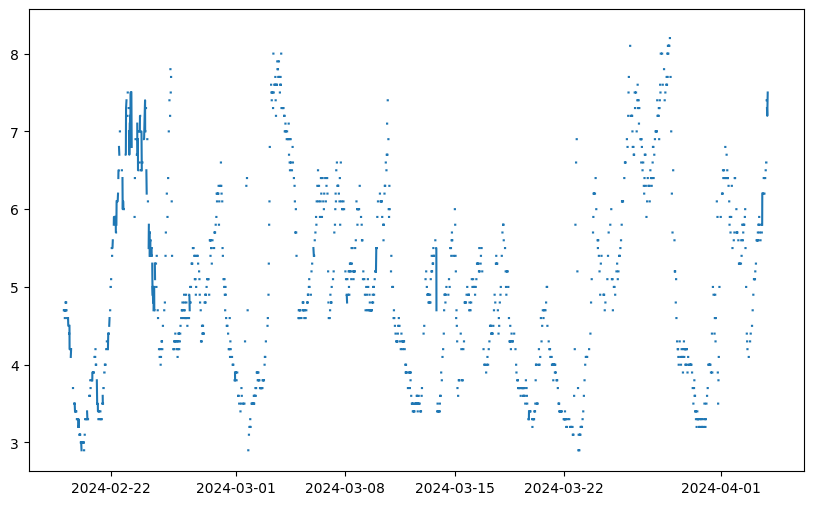

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(ny_buoy["date"], ny_buoy["average_period"]) # including NULL values

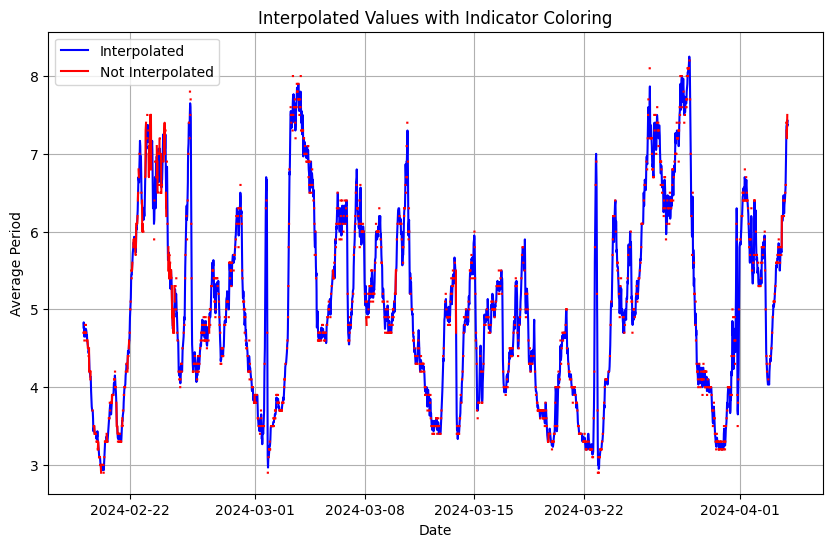

In [24]:
# lets limit the df to 2 columns: date and wave height
ny_buoy_df = ny_buoy[["date","average_period"]]

# Set 'date' column as the index
ny_buoy_df = ny_buoy_df.set_index("date")

ny_buoy_df['average_period_interpolated'] = ny_buoy_df['average_period'].interpolate(method='time') # interpolate missing values based on time
ny_buoy_df['interpolation_indicator'] = ny_buoy_df['average_period'].isna()

ny_buoy_df = ny_buoy_df.reset_index()

plt.figure(figsize=(10, 6))
#plt.plot(ny_buoy_df["average_period"]) # interpolated NULL values

plt.plot(ny_buoy_df['date'][ny_buoy_df['interpolation_indicator']], ny_buoy_df['average_period_interpolated'][ny_buoy_df['interpolation_indicator']], color='blue', label='Interpolated')
plt.plot(ny_buoy_df['date'], ny_buoy_df['average_period'], color='red', label='Not Interpolated')

plt.xlabel('Date')
plt.ylabel('Average Period')
plt.title('Interpolated Values with Indicator Coloring')
plt.legend()

plt.grid(True)
plt.show()

In [52]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

ny_buoy_df.dropna(subset=['average_period'], inplace=True)

train_data, test_data = ny_buoy_df[0:int(len(ny_buoy_df)*0.5)], ny_buoy_df[int(len(ny_buoy_df)*0.5):]
test_data = test_data.reset_index(drop=True)

train_arima = train_data['average_period']
test_arima = test_data['average_period']

history = [x for x in train_arima]
y = test_arima
predictions = list()

# rolling forecasts
for i in range(0, len(y)):

    # predict
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]

    # invert transformed prediction
    predictions.append(yhat)

    # observation
    obs = y[i]
    history.append(obs)

KeyboardInterrupt: 

In [ ]:
# report performance
mse = mean_squared_error(y, predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(y, predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y, predictions))
print('RMSE: '+str(rmse))

MSE: 0.029790461447702643
MAE: 0.09719809275110251
RMSE: 0.17259913513022782


In [ ]:
df = pd.DataFrame(y,predictions)
nan_count_A = df['average_period'].isna().sum()
nan_count_A

1596

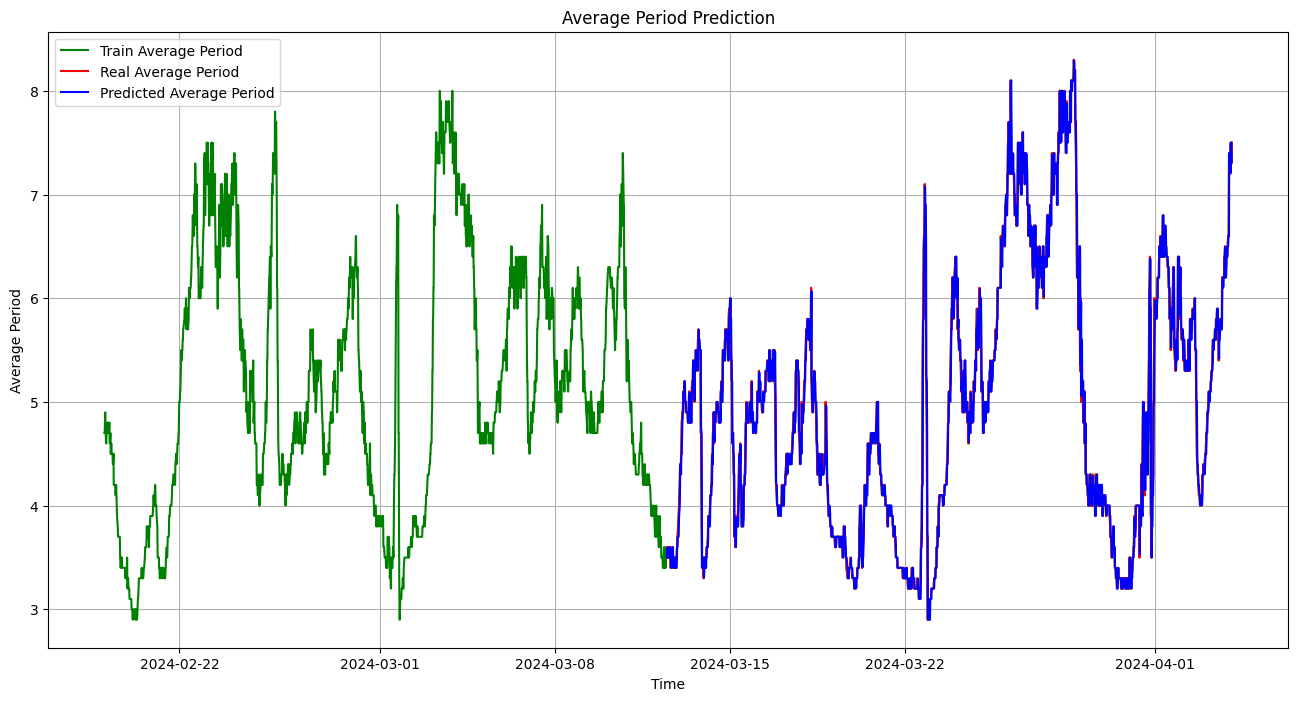

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(ny_buoy_df["date"], ny_buoy_df['average_period'], color='green', label = 'Train Average Period')
plt.plot(test_data["date"], y, color = 'red', label = 'Real Average Period')
plt.plot(test_data["date"], predictions, color = 'blue', label = 'Predicted Average Period')
plt.title('Average Period Prediction')
plt.xlabel('Time')
plt.ylabel('Average Period')
plt.legend()
plt.grid(True)
plt.savefig('arima_model.pdf')
plt.show()

In [38]:
df = pd.DataFrame({'predictions': predictions, 'true': y})
df

,predictions,true
0,3.500000,3.6
1,3.593491,3.5
2,3.506525,3.5
3,3.500000,3.6
4,3.593476,3.5
...,...,...
1663,7.305474,7.2
1664,7.205465,7.5
1665,7.483530,7.5
1666,7.500000,7.3


In [46]:
from pmdarima import auto_arima

# Assuming you have a pandas Series `train_arima` for training
model = auto_arima(train_arima, start_p=0, start_q=0,
                   max_p=5, max_q=5, d=None, # Letting model to determine 'd'
                   seasonal=False,  # Set to True if the series is seasonal
                   trace=True,
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-812.309, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-817.383, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-818.436, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-814.285, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-817.583, Time=0.70 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-821.360, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-826.954, Time=0.77 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-832.881, Time=1.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-830.203, Time=0.86 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-830.953, Time=2.58 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-844.032, Time=2.44 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-845.972, Time=1.28 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-839.034, Time=0.55 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-844.005, Time=2.77 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept

In [55]:
# testing whether data is stationary

from statsmodels.tsa.stattools import adfuller

# Assuming `data` is your time series data.
result = adfuller(ny_buoy_df["average_period"])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.366398
p-value: 0.000340
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [56]:
# training without rolling predictions

# Fit the ARIMA model on the entire training dataset
model = ARIMA(train_arima, order=(1,1,3), trend = 'n')
model_fit = model.fit()

# Forecast the future points. Replace 'len(test_arima)' with your desired forecast length
forecast_steps = len(test_arima)  # Number of steps you want to forecast, equivalent to the test dataset size
forecast = model_fit.forecast(steps=forecast_steps)

In [57]:
forecast

1667    3.522006
1668    3.523638
1669    3.526341
1670    3.527980
1671    3.528975
          ...   
3330    3.530509
3331    3.530509
3332    3.530509
3333    3.530509
3334    3.530509
Name: predicted_mean, Length: 1668, dtype: float64

In [58]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit the SARIMA model on the entire training dataset
# Replace p, d, q with your ARIMA parameters and P, D, Q, m with your seasonal parameters
model = SARIMAX(train_arima, order=(1,1,3), seasonal_order=(1,1,1,12), trend='n')
model_fit = model.fit()

# Forecast the future points
forecast_steps = len(test_arima)  # Number of steps you want to forecast
forecast = model_fit.forecast(steps=forecast_steps)

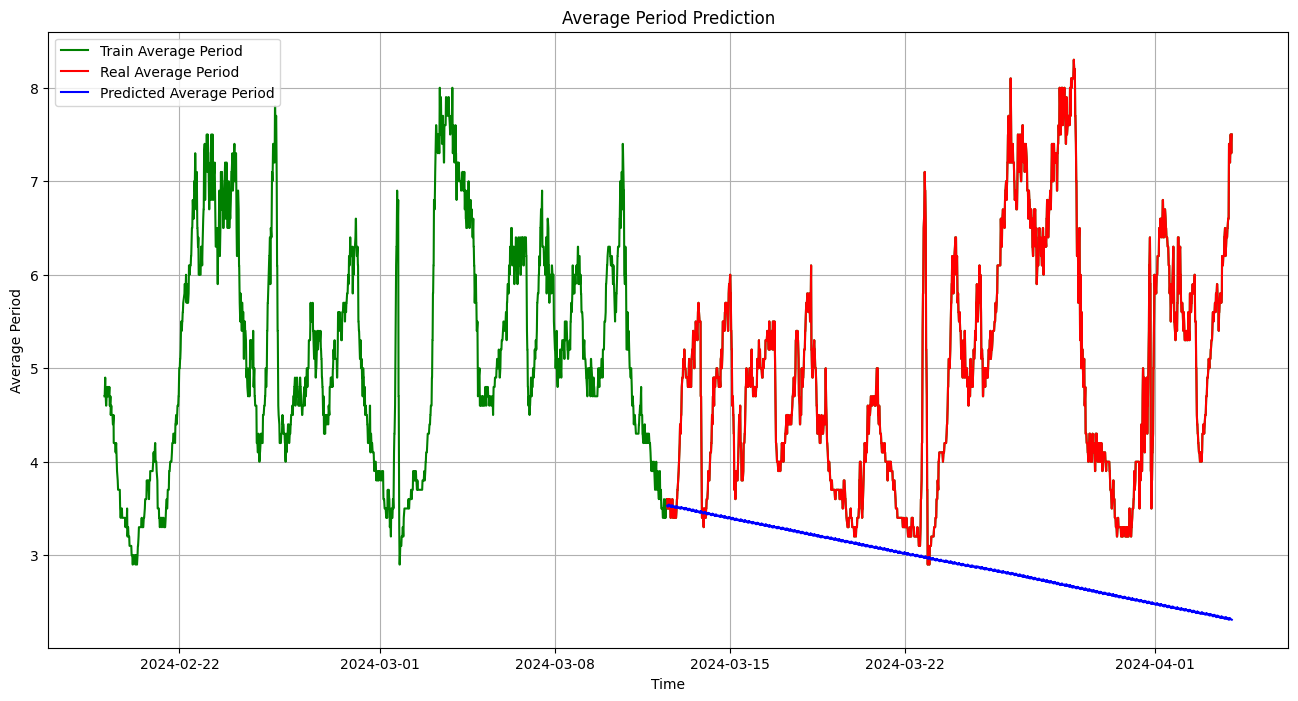

In [59]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(ny_buoy_df["date"], ny_buoy_df['average_period'], color='green', label = 'Train Average Period')
plt.plot(test_data["date"], y, color = 'red', label = 'Real Average Period')
plt.plot(test_data["date"], forecast, color = 'blue', label = 'Predicted Average Period')
plt.title('Average Period Prediction')
plt.xlabel('Time')
plt.ylabel('Average Period')
plt.legend()
plt.grid(True)
plt.savefig('arima_model.pdf')
plt.show()